## Отчёт по практическому заданию 1 ОММО.

### 3. Формулы для логистической регрессии.

$f(x) = \frac{1}{m} \sum_i log(1 + exp(-b_i * a_i^T x)) + \frac{r}{2} ||x||_2^2 = \frac{1}{m} logaddexp(-b * Ax) + \frac{r}{2} ||x||_2^2$ - произведение Адамара. А $logaddexp(a) = np.logaddexp(0, a)$

Продифференцируем:
$\\
df(x) = d(\frac{1}{m} logaddexp(-b * Ax) + \frac{r}{2} ||x||_2^2) = 
\frac{1}{m} d logaddexp(-b * Ax) + rx^Tdx =
\frac{1}{m} J_{logaddexp}(-b * Ax)d(-b * Ax) + rx^Tdx = \\
\frac{1}{m} J_{logaddexp}(-b * Ax)diag(-b)Adx + rx^Tdx = \Bigg[J_{logaddexp} = diag(logaddexp'(-b * Ax)\Bigg] =\\
\frac{1}{m} (-b * logaddexp'(-b * Ax))Adx + rx^Tdx = 
\langle \frac{1}{m} A^T(-b * logaddexp'(-b * Ax)) + rx, dx \rangle\\
\Delta f(x) = \frac{1}{m} A^T(-b * logaddexp'(-b * Ax)) + rx\\
logaddexp'(-b * Ax) = 
\frac{\exp{[-b * Ax]}}{1+\exp{[-b * Ax]}}=
I - \frac{1}{1+\exp{[-b * Ax]}}
\\
$
<br>
$
ddf(x) = d(\langle \frac{1}{m} A^Tdiag(-b)diag(logaddexp'(-b * Ax) + rx, dx \rangle) =
\langle \frac{1}{m} d(A^Tdiag(-b)diag(logaddexp'(-b * Ax)) + rdx, dx \rangle =\\
\langle \frac{1}{m} A^Tdiag(-b)diag(logaddexp''(-b * Ax)diag(-b)Adx + rdx, dx \rangle = \Bigg[diag(-b)diag(b)=I\Bigg]=
\langle \frac{1}{m} A^Tdiag(logaddexp''(-b * Ax)A + Ir, dx^2 \rangle\\
\Delta^2 f(x) = \frac{1}{m} A^Tdiag(logaddexp''(-b * Ax))A + Ir\\
logaddexp''(-b * Ax) = 
\frac{\exp{[-b * Ax]}}{(1+\exp{[-b * Ax]})^2} = 
\frac{1}{1+\exp{[-b * Ax]}}(I-\frac{1}{1+\exp{[-b * Ax]}})
$

### Все библиотеки и функция

In [1]:
import oracles
import numpy as np
import random
import pandas as pd
import os
import skdatasets.repositories.libsvm as libsvm
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, diags
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from inspect import getfullargspec
from itertools import product
from optimization import gradient_descent, newton
from plot_trajectory_2d import plot_levels, plot_trajectory

2022-02-19 18:45:35.616639: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-19 18:45:35.616661: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### 5. Проверим верно ли мы считаем градиент и гессиан.

In [2]:
def are_grad_and_hess_correct(log_reg_oracle, x, tolerance=1e-2):
    return np.allclose(log_reg_oracle.grad(x), oracles.grad_finite_diff(log_reg_oracle.func, x), atol=tolerance)\
        and np.allclose(log_reg_oracle.hess(x), oracles.hess_finite_diff(log_reg_oracle.func, x), atol=tolerance)

#### Проверка

In [3]:
are_correct = True
shape = 9
for i in range(100):
    A = csr_matrix((np.random.rand(shape, shape) - 0.5) * 10 + 1)
    x = (np.random.rand(shape) - 0.5) * 10 + 1
    b = np.random.randint(0, 1, size=shape) * 2 - 1
    log_reg_oracle = oracles.create_log_reg_oracle(A, b, 2)
    are_correct = are_correct and are_grad_and_hess_correct(log_reg_oracle, x)

for i in range(100):
    A = (np.random.rand(shape, shape) - 0.5) * 10 + 1
    x = (np.random.rand(shape) - 0.5) * 10 + 1
    b = np.random.randint(0, 1, size=shape) * 2 - 1
    log_reg_oracle = oracles.create_log_reg_oracle(A, b, 2)
    are_correct = are_correct and are_grad_and_hess_correct(log_reg_oracle, x)

print('Hessyan and gradient are correct:', are_correct)

Hessyan and gradient are correct: True


### Эксперемент 1.

#### Подготовка.

* Для красочных картинок в этой секции прошу скопировать файл `plot_trajectory_2d.py` (изменена функция `plot_trajectory`)

In [27]:
def plot_levels_from_oracle(oracle, i=0):
    plt.title('Levels for matrix ' + str(i))
    plot_levels(oracle.func)

def plot_trajectory_from_oracle(oracle, x, i=0, line_search_options=None, color='r'):
    _, _, history = gradient_descent(oracle, x, trace=True, line_search_options=line_search_options, max_iter=20)
    label = str(x) + ((' ' + str(line_search_options)) if line_search_options is not None else '')
    if 'color' in getfullargspec(plot_trajectory).args:
        plot_trajectory(oracle.func, history['x'], color=color, label=label)
    else:
        plot_trajectory(oracle.func, history['x'], label=label)
    plt.title('Trajectory over levels for matrix ' + str(i))

def plot_trajectory_over_x_and_lt_options(axs, x, lt_options=None, color='r'):
    for i, (ax, oracle) in enumerate(zip(axs, array_oracles)):
        plt.sca(ax)
        plot_levels_from_oracle(oracle, i)
        plot_trajectory_from_oracle(oracle, x, i, lt_options, color=color)
        plt.legend()

array_oracles = [
  oracles.QuadraticOracle(np.diag([1, 1]), np.array([1, 0.5])),
  oracles.QuadraticOracle(np.array( [[10, 1], [1, 2]] ), np.array([0.2, -1])),
  oracles.QuadraticOracle(np.array( [[4, -2.5], [-2.5, 2]] ), np.array([-1, 0.2]))
]

#### Уровни

/home/panesher/code/Machine-Learning/OMML/task1/plot_trajectory_2d.py:31: UserWarning: The following kwargs were not used by contour: 'linewidth'
  CS = plt.contour(X, Y, Z, levels=levels, colors='k', linewidth=4.0)


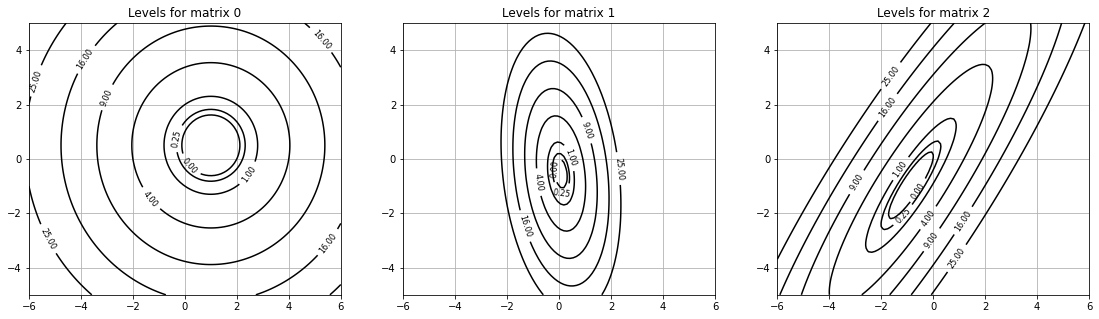

In [28]:
_, axs = plt.subplots(1, 3, figsize=(19,5))
for i, (ax, oracle) in enumerate(zip(axs, array_oracles)):
    plt.sca(ax)
    plot_levels_from_oracle(oracle, i)

#### Вульф

* Как мы видим Вульф довольно хорошо подстраивает шаг, так, что быстро попадает в оптимум в целом.
* Качественный метод

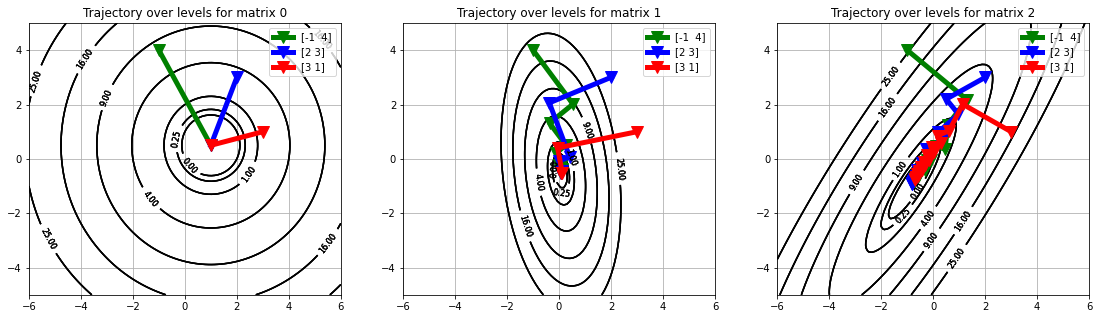

In [38]:
_, axs = plt.subplots(1, 3, figsize=(19,5))
plot_trajectory_over_x_and_lt_options(axs, np.array([-1, 4]), color='g')
plot_trajectory_over_x_and_lt_options(axs, np.array([2, 3]), color='b')
plot_trajectory_over_x_and_lt_options(axs, np.array([3, 1]), color='r')

#### Константный

* Очень зависит от константы и может выйти из градиента при большой константе
* При маленькой константе будет долго сходиться

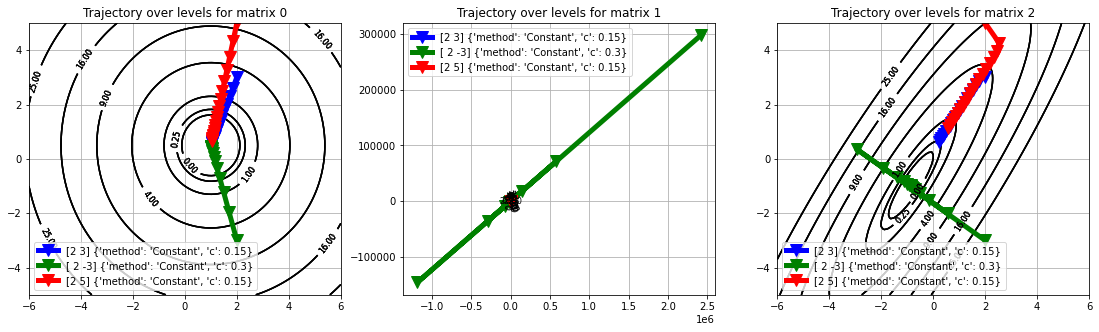

In [37]:
_, axs = plt.subplots(1, 3, figsize=(19,5))
plot_trajectory_over_x_and_lt_options(axs, np.array([2, 3]), lt_options={'method': 'Constant', 'c': 0.15}, color='b')
plot_trajectory_over_x_and_lt_options(axs, np.array([2, -3]), lt_options={'method': 'Constant', 'c': 0.3}, color='g')
plot_trajectory_over_x_and_lt_options(axs, np.array([2, 5]), lt_options={'method': 'Constant', 'c': 0.15})

#### Амирхо

* При низком $с_1$ может довольно делать большие шаги (потому что накладывается маленькое ограничение на оптимизацию)
* При низком $\alpha_0$ будет медленно сходиться

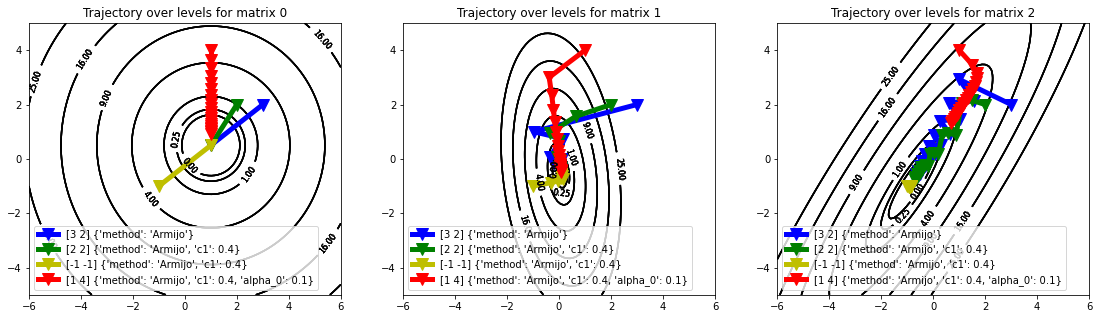

In [33]:
_, axs = plt.subplots(1, 3, figsize=(19,5))
plot_trajectory_over_x_and_lt_options(axs, np.array([3, 2]), lt_options={'method': 'Armijo'}, color='b')
plot_trajectory_over_x_and_lt_options(axs, np.array([2, 2]), lt_options={'method': 'Armijo', 'c1': 0.4}, color='g')
plot_trajectory_over_x_and_lt_options(axs, np.array([-1, -1]), lt_options={'method': 'Armijo', 'c1': 0.4}, color='y')
plot_trajectory_over_x_and_lt_options(axs, np.array([1, 4]), lt_options={'method': 'Armijo', 'c1': 0.4, 'alpha_0': 0.1})

#### О функциях в целом

* Как бы это ни было очевидно особое градиент оказывает большое влияние на сходимость
* При больших градиентах наша функция рискует не сойтись (при константом методе)
* При маленьких градиентах есть риск затухания

### Эксперемент 2.

#### Подготовка

In [150]:
def set_random_seed(seed):
    np.random.seed(seed)
    random.seed(seed)

def get_random_array_x(shape, cnt=100):
    array_x = []
    for _ in range(cnt):
        array_x.append(np.random.rand(shape) * 10 - 20)

    return array_x

def avg_time_to_convergence(n, k, array_x=None, cnt=100):
    if array_x is None:
        array_x = get_random_array_x(n, cnt)
    oracle = oracles.QuadraticOracle(
      diags(np.random.randint(1, k + 1, n)), np.random.rand(n) * 10 - 20)

    result = 0
    for x in array_x:
        _, _, history = gradient_descent(oracle, x, trace=True)
        result += len(history['time']) / cnt

    return result

#### Подсчёт

In [201]:
set_random_seed(991)
launches = range(5)
array_n = np.logspace(1, 4, 4, dtype=int)
array_k = np.logspace(1, 4, 10, dtype=int)
df = pd.DataFrame(columns=['i', 'n', 'k', 'convergence_time'])
for i, (launch, n, k) in enumerate(product(launches, array_n, array_k)):
    df.loc[i] = [launch, n, k, avg_time_to_convergence(n, k)]

/home/panesher/.anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


#### Результаты

Замечу, что пунктирные линии это обычные графики сходимости, а обычные линии - усреднение
* Зависимость от n (размер пространства) близка к константной при значениях n > 10. При n = 10 она меньше остальных.
* Дисперсия сходимости имеет обратную зависимость с n. Это понятно, чем меньше матрица, тем дальше она от средней.
* Зависимость от k (число обусловленности) сначала резко растёт, а потом становиться почти константной.

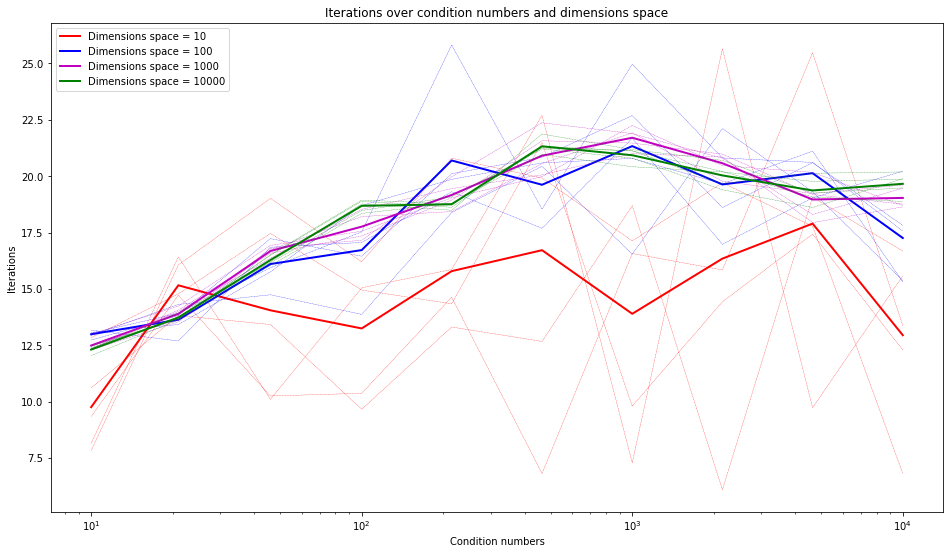

In [207]:
df['avg_time'] = 0
colors = ['r', 'b', 'm', 'g']
plt.figure(figsize=(16, 9))
for n, color in zip(array_n, colors):
    for i in launches:
        df_ni = df[(df['i'] == i) & (df['n'] == n)]
        plt.plot(df_ni['k'], df_ni['convergence_time'], color=color, linestyle='--', linewidth=.3)
        df.loc[(df['i'] == 0) & (df['n'] == n), 'avg_time'] += (df_ni['convergence_time'].to_numpy()) / len(launches)

    df_n0 = df[(df['i'] == 0) & (df['n'] == n)]
    
    plt.plot(df_n0['k'], df_n0['avg_time'], color=color, linewidth=2, label='Dimensions space = ' + str(n))

plt.xlabel('Condition numbers')
plt.ylabel('Iterations')
plt.xscale('log')
plt.title('Iterations over condition numbers and dimensions space')
plt.legend()
plt.show()

### Эксперемент 3.

#### Подготовка данных

Датасеты из этой [статьи](https://jamesmccaffrey.wordpress.com/2018/03/14/datasets-for-binary-classification/).

In [109]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wpbc.data -P datasets
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt -P datasets
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/haberman/haberman.data -P datasets

In [164]:
data_config = {
    'wpbc.data': None,
    'haberman.data': None,
    'data_banknote_authentication.txt': None,
}

for name in data_config.keys():
    data_config[name] = pd.read_csv(str(os.path.join('datasets', name)), header=None)

In [165]:
df = data_config['wpbc.data']
df.drop(0, inplace=True, axis='columns')
df.drop(34, inplace=True, axis='columns')
df.loc[df[1] == 'N', 35] = -1
df.loc[df[1] != 'N', 35] = 1
df.drop(1, inplace=True, axis='columns')

df = data_config['haberman.data']
df.loc[df[3] == 2, 3] = -1

df = data_config['data_banknote_authentication.txt']
df.loc[df[4] == 0, 4] = -1

for name in data_config.keys():
    data_config[name] = np.array(data_config[name])

#### Обучение и тест параметра

In [193]:
df = pd.DataFrame(columns=['name', 'eps', 'accuracy'])

for i, (eps, (name, data)) in enumerate(product(np.logspace(0, -8, 10), data_config.items())):
    x_train, x_test, y_train, y_test = train_test_split(
        data[:, :-1], data[:, -1], random_state=1402, stratify=data[:, -1], test_size=0.15)
    oracle = oracles.create_log_reg_oracle(x_train, y_train, 1. / x_train.shape[1])
    x, msg, _ = newton(oracle, np.zeros(x_train.shape[1]), tolerance=eps)
    pred = np.sign(x_test @ x)
    pred[pred == 0] = -1
    df.loc[i] = [name, eps, 1 - accuracy_score(y_test, pred)]

#### Результаты

Как видно только eps = 1 плохо, потому что по сути прогноз в 0 (который был переопределён в -1). Далее улучшения были незначительны, возможно из-за простоты данных. Всё таки на wbpc (где больше параметров) мы смогли дообучиться

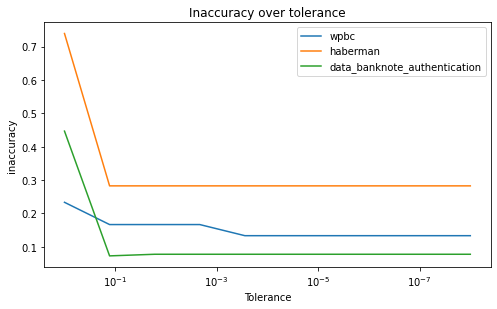

In [201]:
plt.figure(figsize=(8, 4.5))
for name, _ in data_config.items():
    data = df[df['name'] == name]
    plt.plot(data['eps'], data['accuracy'], label=name.split('.')[0])

plt.legend()
plt.title('Inaccuracy over tolerance')
plt.xlabel('Tolerance')
plt.ylabel('inaccuracy')
plt.gca().invert_xaxis()
plt.xscale('log')

### Эксперемент 4.

#### Подготовка данных.

In [3]:
def _load(collection, name, dirname=None):
    """Load dataset."""
    filename = libsvm._fetch_partition(collection, name + '_train.binary', '', dirname=dirname)
    filename_t = libsvm._fetch_partition(collection, name + '_test.binary', '', dirname=dirname)
    if filename_t is not None and filename is not None:
        X, y, X_test, y_test = libsvm.load_svmlight_files([filename, filename_t])
        X_remaining = y_remaining = cv = None
    elif filename is not None:
        X, y = libsvm.load_svmlight_file(filename)
        X_test = y_test = X_remaining = y_remaining = cv = None

    return X, y, X_test, y_test, cv, X_remaining, y_remaining


def fetch_rcv1(collection='binary', name='rcv1', data_home=None):
    """Fetch LIBSVM dataset.

    Fetch a LIBSVM dataset by collection and name. More info at
    https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets.

    Parameters
    ----------
    collection : string
        Collection name.
    name : string
        Dataset name.
    data_home : string or None, default None
        Specify another download and cache folder for the data sets. By default
        all scikit-learn data is stored in ‘~/scikit_learn_data’ subfolders.

    Returns
    -------
    data : Bunch
        Dictionary-like object with all the data and metadata.
    """
    if collection not in libsvm.COLLECTIONS:
        raise Exception('Avaliable collections are ' + str(list(libsvm.COLLECTIONS)))
    dirname = os.path.join(libsvm.get_data_home(data_home=data_home), 'libsvm',
                           collection, name.replace('/', '-'))
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    X, y, X_test, y_test, cv, X_remaining, y_remaining = _load(collection, name,
                                                               dirname=dirname)
    data = libsvm.Bunch(data=X, target=y, data_test=X_test, target_test=y_test,
                        inner_cv=cv, outer_cv=None, data_remaining=X_remaining,
                        target_remaining=y_remaining, DESCR=name)
    return data

In [9]:
w8a = libsvm.fetch('binary', 'w8a')
# news20 = libsvm.fetch('binary', 'news20.binary')
gisette = libsvm.fetch('binary', 'gisette_scale')
# real_sim = libsvm.fetch('binary', 'real-sim')
# rcv1 = fetch_rcv1()

In [10]:
data_config = {
    'w8a': w8a,
    # 'news20': news20,
    'gisette': gisette,
    # 'real_sim': real_sim,
    # 'rcv1': rcv1
}

for name, data in data_config.items():
    print(name, '.shape = ', data['data'].shape, '. ', name, ' has test: ', data['data_test'] is not None, sep='')

w8a.shape = (49749, 300). w8a has test: True
gisette.shape = (6000, 5000). gisette has test: True


#### Обучение

In [2]:
history_config = {
    'newton': {},
    'grad': {},
}

zero_grad = {}

In [11]:
for name, data in data_config.items():
    oracle = oracles.create_log_reg_oracle(data['data'], data['target'], 1. / data['data'].shape[1])
    _, _, history = newton(oracle, np.zeros(data['data'].shape[1]), trace=True)
    history_config['newton'].update({name : history})
    _, _, history = gradient_descent(oracle, np.zeros(data['data'].shape[1]), trace=True)
    zero_grad.update({name : np.linalg.norm(oracle.grad(np.zeros(data['data'].shape[1])))})
    history_config['grad'].update({name : history})

#### Результаты

* Как мы видим Ньютон на каждой итерации работал дольше, зато количество итераций было явно меньше, чем у градиентного спуска.
* Скорость 1 итерации градиентного спуска в разы быстрее.
* Результаты значений функции и нормы градиента получились довольно близкими в разных методах. Для нормы градиента оно и понятно: мы оканчиваем при условии, что наш градиент меньше некоторой константы ($\varepsilon||\Delta f(x_0)||^2$). А близость градиентов с 1 начальной точкой часто влечет за собой схожие значения (если мы не перепрыгнули в ходе работы метода локальный минимум).

**__Итог:__** Если вам нужен метод который сойдётся быстро по времени - используйте градиент, если же быстро по количеству итераций - используйте метод Ньютона (если у вас хватит памяти конечно).

ПС На остальные датасеты не хватило памяти, чтобы реалоцировать результаты перемножений. 

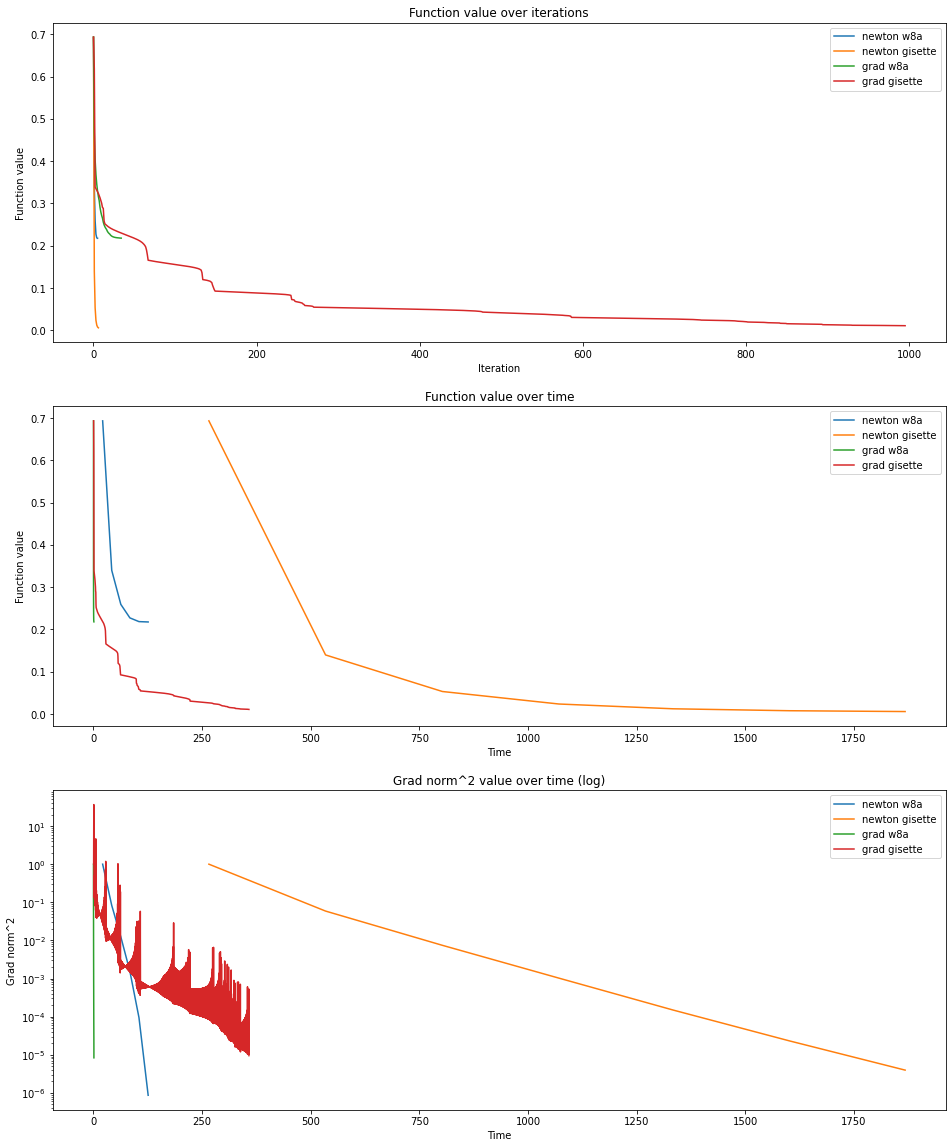

In [13]:
_, axs = plt.subplots(3, 1, figsize=(16, 20))

for method in history_config:
    for name, history in history_config[method].items():
        plt.sca(axs[0])
        plt.plot(range(len(history['func'])), history['func'], label=method + ' ' + name)
        plt.xlabel('Iteration')
        plt.title('Function value over iterations')

        plt.sca(axs[1])
        plt.plot(history['time'], history['func'], label=method+ ' ' + name)
        plt.xlabel('Time')
        plt.title('Function value over time')

        plt.sca(axs[2])
        plt.plot(history['time'], (np.array(history['grad_norm']) / zero_grad[name]) ** 2, label=method+ ' ' + name)
        plt.yscale('log')
        plt.xlabel('Time')
        plt.title('Grad norm^2 value over time (log)')

for ax in axs:
    plt.sca(ax)
    plt.legend()
    plt.ylabel('Function value')

plt.sca(ax)
plt.ylabel('Grad norm^2')
plt.show()